# 1. Project Overview

This notebook fine-tunes a small Portuguese BERT model for Named Entity Recognition (NER) on Brazilian legal texts using the LeNER-Br dataset.

In [3]:
# Optional workspace setup. Uncomment to set HF_TOKEN here if it is not already exported.
# import os
# os.environ["HF_TOKEN"] = "<your-hf-token>"

# 2. Dataset: LeNER-Br (Brazilian Legal NER)

LeNER-Br contains Brazilian court decisions annotated with entities such as ORGANIZACAO, PESSOA, TEMPO, LOCAL, LEGISLACAO, and JURISPRUDENCIA. The dataset is loaded from Hugging Face (`peluz/lener_br`) and comes with train, validation, and test splits.

In [4]:
import os

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
)


## Load the dataset and inspect splits

Authenticate with `HF_TOKEN` if the dataset requires a gated download. The next cells show a sample and basic sentence-length statistics to guide the tokenization setup.

In [5]:
dataset_id = "peluz/lener_br"

# Attempt to read the Hugging Face token from the environment (required if the dataset is gated).
hf_token = os.getenv("HF_TOKEN")

lener = load_dataset(dataset_id, token=hf_token)
print(lener)

split_sizes = {split: len(lener[split]) for split in lener}
for split, size in split_sizes.items():
    print(f"{split}: {size} examples")


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})
train: 7828 examples
validation: 1177 examples
test: 1390 examples


In [6]:
# Preview a single annotated example
print(lener["train"][0])


{'id': '0', 'tokens': ['EMENTA', ':', 'APELAÇÃO', 'CÍVEL', '-', 'AÇÃO', 'DE', 'INDENIZAÇÃO', 'POR', 'DANOS', 'MORAIS', '-', 'PRELIMINAR', '-', 'ARGUIDA', 'PELO', 'MINISTÉRIO', 'PÚBLICO', 'EM', 'GRAU', 'RECURSAL', '-', 'NULIDADE', '-', 'AUSÊNCIA', 'DE', 'INTERVENÇÃO', 'DO', 'PARQUET', 'NA', 'INSTÂNCIA', 'A', 'QUO', '-', 'PRESENÇA', 'DE', 'INCAPAZ', '-', 'PREJUÍZO', 'EXISTENTE', '-', 'PRELIMINAR', 'ACOLHIDA', '-', 'NULIDADE', 'RECONHECIDA', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


### Sentence-length statistics

Quick descriptive stats to choose a reasonable maximum sequence length for BERT.

Average tokens per sentence: 29.29
Max sentence length: 755


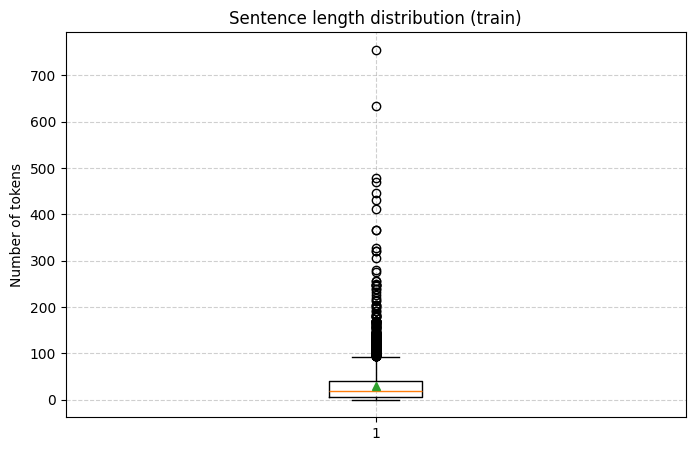

In [7]:
sizes = [len(sample["tokens"]) for sample in lener["train"]]

avg_len = sum(sizes) / len(sizes)
max_len = max(sizes)

print(f"Average tokens per sentence: {avg_len:.2f}")
print(f"Max sentence length: {max_len}")

plt.figure(figsize=(8, 5))
plt.boxplot(sizes, vert=True, showmeans=True)
plt.title("Sentence length distribution (train)")
plt.ylabel("Number of tokens")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# 3. Label Space and Task Definition

LeNER-Br uses BIO tags for legal entities (e.g., ORGANIZACAO, PESSOA, TEMPO, LOCAL, LEGISLACAO, and JURISPRUDENCIA) plus the outside tag `O`. The mapping below is reused for the token-classification head.

In [8]:
ner_feature = lener["train"].features["ner_tags"]
label_list = ner_feature.feature.names
num_labels = len(label_list)
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
print(label_list)
print(f"Number of labels: {num_labels}")


['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA']
Number of labels: 13


# 4. Model: Portuguese BERT (small LM)

We fine-tune `neuralmind/bert-base-portuguese-cased` for token classification. The `Trainer` uses `seqeval` to report precision, recall, F1, and accuracy.

In [9]:
checkpoint = "neuralmind/bert-base-portuguese-cased"

model = AutoModelForTokenClassification.from_pretrained(
    checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id
)

metric = evaluate.load("seqeval")

def align_predictions(predictions, labels):
    pred_ids = np.argmax(predictions, axis=-1)
    true_labels, true_preds = [], []
    for pred_sequence, label_sequence in zip(pred_ids, labels):
        aligned_labels = []
        aligned_preds = []
        for pred_id, label_id in zip(pred_sequence, label_sequence):
            if label_id == -100:
                continue
            aligned_labels.append(label_list[label_id])
            aligned_preds.append(label_list[pred_id])
        true_labels.append(aligned_labels)
        true_preds.append(aligned_preds)
    return true_preds, true_labels


def compute_metrics(p):
    predictions, labels = p
    true_preds, true_labels = align_predictions(predictions, labels)
    results = metric.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Tokenization and Label Alignment

Word-level labels are aligned to subword tokens. Subtokens repeat the parent word label while padding tokens use `-100` so they are ignored by the loss. `MAX_LEN` is set based on the sentence-length stats above.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

MAX_LEN = 256

def tokenize_and_align(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        max_length=MAX_LEN,
    )

    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_word = None
        label_ids = []
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev_word:
                label_ids.append(labels[word_id])
            else:
                # Repeat the same label on subtokens to keep alignment across pieces.
                label_ids.append(labels[word_id])
            prev_word = word_id
        all_labels.append(label_ids)

    tokenized["labels"] = all_labels
    return tokenized


tokenized_ds = lener.map(
    tokenize_and_align,
    batched=True,
    remove_columns=["tokens", "ner_tags", "id"],
)

print(tokenized_ds["train"][0].keys())


Map:   0%|          | 0/1177 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


# 6. Training Configuration

Hyperparameters for the initial run (Deliverable 1): learning rate 5e-5, 3 epochs, batch size 8/8, weight decay 0.01, mixed precision on GPU (`fp16`), max sequence length 256. Evaluation and checkpoints run at each epoch.


In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer)
use_fp16 = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="results_lenerbr",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    fp16=use_fp16,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_predictions = trainer.predict(tokenized_ds["validation"])
true_preds, true_labels = align_predictions(
    eval_predictions.predictions, eval_predictions.label_ids
)
label_metrics = metric.compute(predictions=true_preds, references=true_labels)
core_metrics = {
    "precision": label_metrics["overall_precision"],
    "recall": label_metrics["overall_recall"],
    "f1": label_metrics["overall_f1"],
    "accuracy": label_metrics["overall_accuracy"],
}


C:\Users\diogo\AppData\Local\Temp\ipykernel_3640\2453371608.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.124800,nan,0.855523,0.840393,0.847891,0.971203
2,0.034200,nan,0.842406,0.902183,0.871270,0.974882
3,0.017100,nan,0.880498,0.896070,0.888216,0.977710


# 7. Initial Training Results

Aggregate validation metrics and per-entity scores are printed below for quick reference.

In [12]:
print("Validation metrics (seqeval):")
for name, value in core_metrics.items():
    print(f"  {name.capitalize():<10}: {value:.4f}")

entity_rows = [
    (label, scores["precision"], scores["recall"], scores["f1"], scores["number"])
    for label, scores in label_metrics.items()
    if not label.startswith("overall_")
]

if entity_rows:
    print("\nPer-entity scores:")
    header = f"{'Label':<18} {'P':>6} {'R':>6} {'F1':>6} {'N':>6}"
    print(header)
    print("-" * len(header))
    for label, p, r, f1, n in entity_rows:
        print(f"{label:<18} {p:6.3f} {r:6.3f} {f1:6.3f} {n:6d}")

save_dir = "models/lenerbr_bert_base"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"\nModel and tokenizer saved to: {save_dir}")


Validation metrics (seqeval):
  Precision : 0.8805
  Recall    : 0.8961
  F1        : 0.8882
  Accuracy  : 0.9777

Per-entity scores:
Label                   P      R     F1      N
----------------------------------------------
JURISPRUDENCIA      0.677  0.729  0.702    657
LEGISLACAO          0.883  0.861  0.872    562
LOCAL               0.817  0.932  0.870    191
ORGANIZACAO         0.887  0.869  0.878   1323
PESSOA              0.952  0.978  0.965   1033
TEMPO               0.967  0.986  0.977    814

Model and tokenizer saved to: models/lenerbr_bert_base


## 7.1 Token-based vs. Entity-based Evaluation

The cell below flattens the validation predictions/labels to calculate precision/recall/F1/accuracy per token (micro) in BIO, allowing comparison of the two perspectives.


In [13]:
# Token-level metrics flatten the aligned labels (ignore padding marked as -100).
token_pred_ids = np.argmax(eval_predictions.predictions, axis=-1)
true_label_ids = eval_predictions.label_ids

flat_preds, flat_labels = [], []
for pred_seq, label_seq in zip(token_pred_ids, true_label_ids):
    for pred_id, label_id in zip(pred_seq, label_seq):
        if label_id == -100:
            continue
        flat_preds.append(int(pred_id))
        flat_labels.append(int(label_id))

token_precision = evaluate.load("precision")
token_recall = evaluate.load("recall")
token_f1 = evaluate.load("f1")
token_accuracy = evaluate.load("accuracy")

token_metrics = {
    "precision": token_precision.compute(predictions=flat_preds, references=flat_labels, average="micro")["precision"],
    "recall": token_recall.compute(predictions=flat_preds, references=flat_labels, average="micro")["recall"],
    "f1": token_f1.compute(predictions=flat_preds, references=flat_labels, average="micro")["f1"],
    "accuracy": token_accuracy.compute(predictions=flat_preds, references=flat_labels)["accuracy"],
}

print("Token-level metrics (micro, BIO):")
for name, value in token_metrics.items():
    print(f"  {name.capitalize():<10}: {value:.4f}")

print("\nEntity-level metrics (seqeval, spans):")
for name, value in core_metrics.items():
    print(f"  {name.capitalize():<10}: {value:.4f}")

# Per-entity precision/recall/F1 remains available via `label_metrics` printed in the previous cell.


Token-level metrics (micro, BIO):
  Precision : 0.9777
  Recall    : 0.9777
  F1        : 0.9777
  Accuracy  : 0.9777

Entity-level metrics (seqeval, spans):
  Precision : 0.8805
  Recall    : 0.8961
  F1        : 0.8882
  Accuracy  : 0.9777


# 8. Qualitative Analysis: Example Predictions

A single test sentence is decoded to illustrate token-level predictions after fine-tuning.

In [14]:
example = lener["test"][0]
tokens = example["tokens"]

encoding = tokenizer(
    tokens,
    is_split_into_words=True,
    return_tensors="pt",
    truncation=True,
)

word_ids = encoding.word_ids()

device = "cuda" if torch.cuda.is_available() else "cpu"
encoding = {k: v.to(device) for k, v in encoding.items()}
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(**encoding)

pred_ids = outputs.logits.argmax(-1).cpu().numpy()[0]

pred_labels = []
clean_tokens = []
used = set()

for idx, word_id in enumerate(word_ids):
    if word_id is None:
        continue
    if word_id in used:
        continue
    used.add(word_id)
    clean_tokens.append(tokens[word_id])
    pred_labels.append(label_list[pred_ids[idx]])

print("Example sentence:")
print(" ".join(clean_tokens))

print("\nToken-level predictions:")
print(f"{'Token':<20} {'Predicted tag'}")
print("-" * 34)
for token, label in zip(clean_tokens, pred_labels):
    print(f"{token:<20} {label}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Example sentence:
Número do Acórdão ACÓRDÃO 1160/2016 - PLENÁRIO Relator AUGUSTO NARDES Processo 006.010/2000-4 Tipo de processo TOMADA DE CONTAS SIMPLIFICADA ( TCSP ) Data da sessão 11/05/2016 Número da ata 16/2016 Relator da deliberação recorrida Ministra Ana Arraes .

Token-level predictions:
Token                Predicted tag
----------------------------------
Número               O
do                   O
Acórdão              O
ACÓRDÃO              B-JURISPRUDENCIA
1160/2016            I-JURISPRUDENCIA
-                    O
PLENÁRIO             B-ORGANIZACAO
Relator              O
AUGUSTO              B-PESSOA
NARDES               I-PESSOA
Processo             B-JURISPRUDENCIA
006.010/2000-4       I-JURISPRUDENCIA
Tipo                 O
de                   O
processo             O
TOMADA               O
DE                   O
CONTAS               O
SIMPLIFICADA         O
(                    O
TCSP                 O
)                    O
Data                 O
da                

# 9. Next Steps: Robustness, Interpretability, Adversarial Attacks

Planned follow-ups: robustness checks (noise/context perturbations), interpretability analyses (attention/explanations), and adversarial stress-testing for the NER model.